# TP2 Robotica Movel - Roadmap

## Alunos
- Bernardo Nogueira Borges 2020006396
- Daniele Cassia Silva Diniz 2020076874


### Importando Libs

In [208]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import numpy as np

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

### Obtendo Objetos de Interesse

Imagem carregada


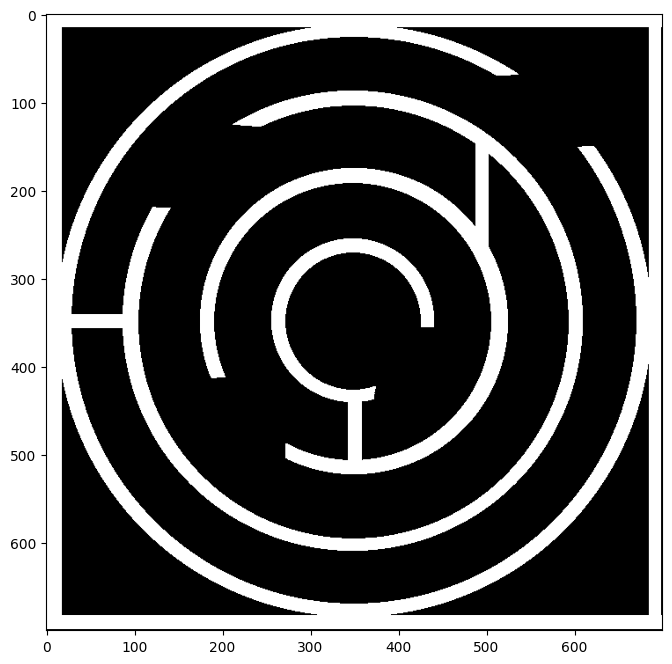

In [209]:
# Objetos de interesse

# Flag para evitar figuras nao utilizadas
CREATE_PLOTS = True

# # Objetivos Maze
# start_node = (6,17)
# end_node = (17,6)

# # Maze
# figsize = (8,8)
# img = 1 - mpimg.imread('../img/invMaze.png')
# dims = [20,20] # Dimensoes do mapa (m)
# cell_size = 1  # Tamanha da celula do grid (m)


# Objetivos Circle
start_node = (5,34)
end_node = (20,20)

# Circle
figsize = (8,8)
img = 1 - mpimg.imread('../img/invCircle.png')
dims = [40,40] # Dimensoes do mapa (m)
cell_size = 1  # Tamanha da celula do grid (m)

# Definir range x e y para a conversao de mapa-cena
# TODO: Definir padrao para nao alterar
sceneXrange = (10,-10) # para direita
sceneYrange = (-10,10) # para baixo

# Apenas para garantir que só teremos esses dois valores
threshold = 0.2
img[img > threshold] = 1
img[img<= threshold] = 0

# Definindo figura 
if CREATE_PLOTS:
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(111,aspect='equal')
    ax.imshow(img, cmap='Greys', origin='upper')

print("Imagem carregada")

### Definindo Grid

Grid definida
40
40


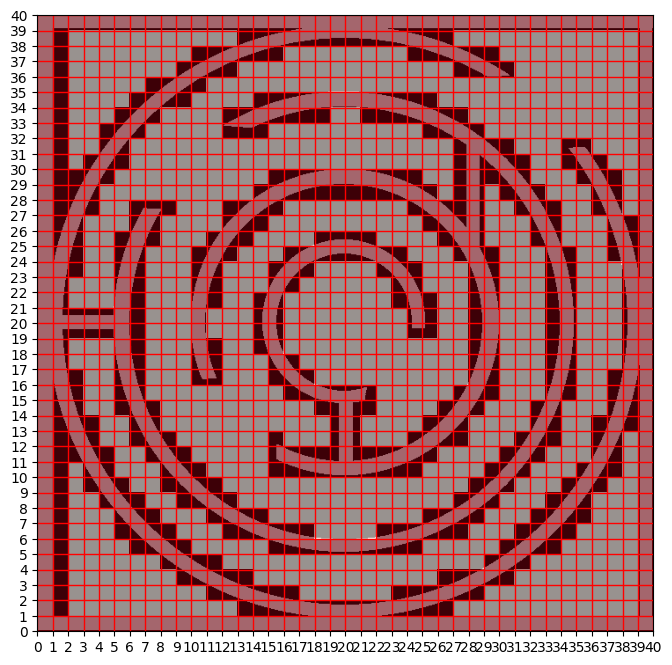

In [210]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array(dims)

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

gridXrange = (0,cols-1) # para direita
gridYrange = (0,rows-1) # para baixo


# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

if CREATE_PLOTS:
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

print("Grid definida")
print(rows)
print(cols)

### Criando o Grafo para o nosso Grid

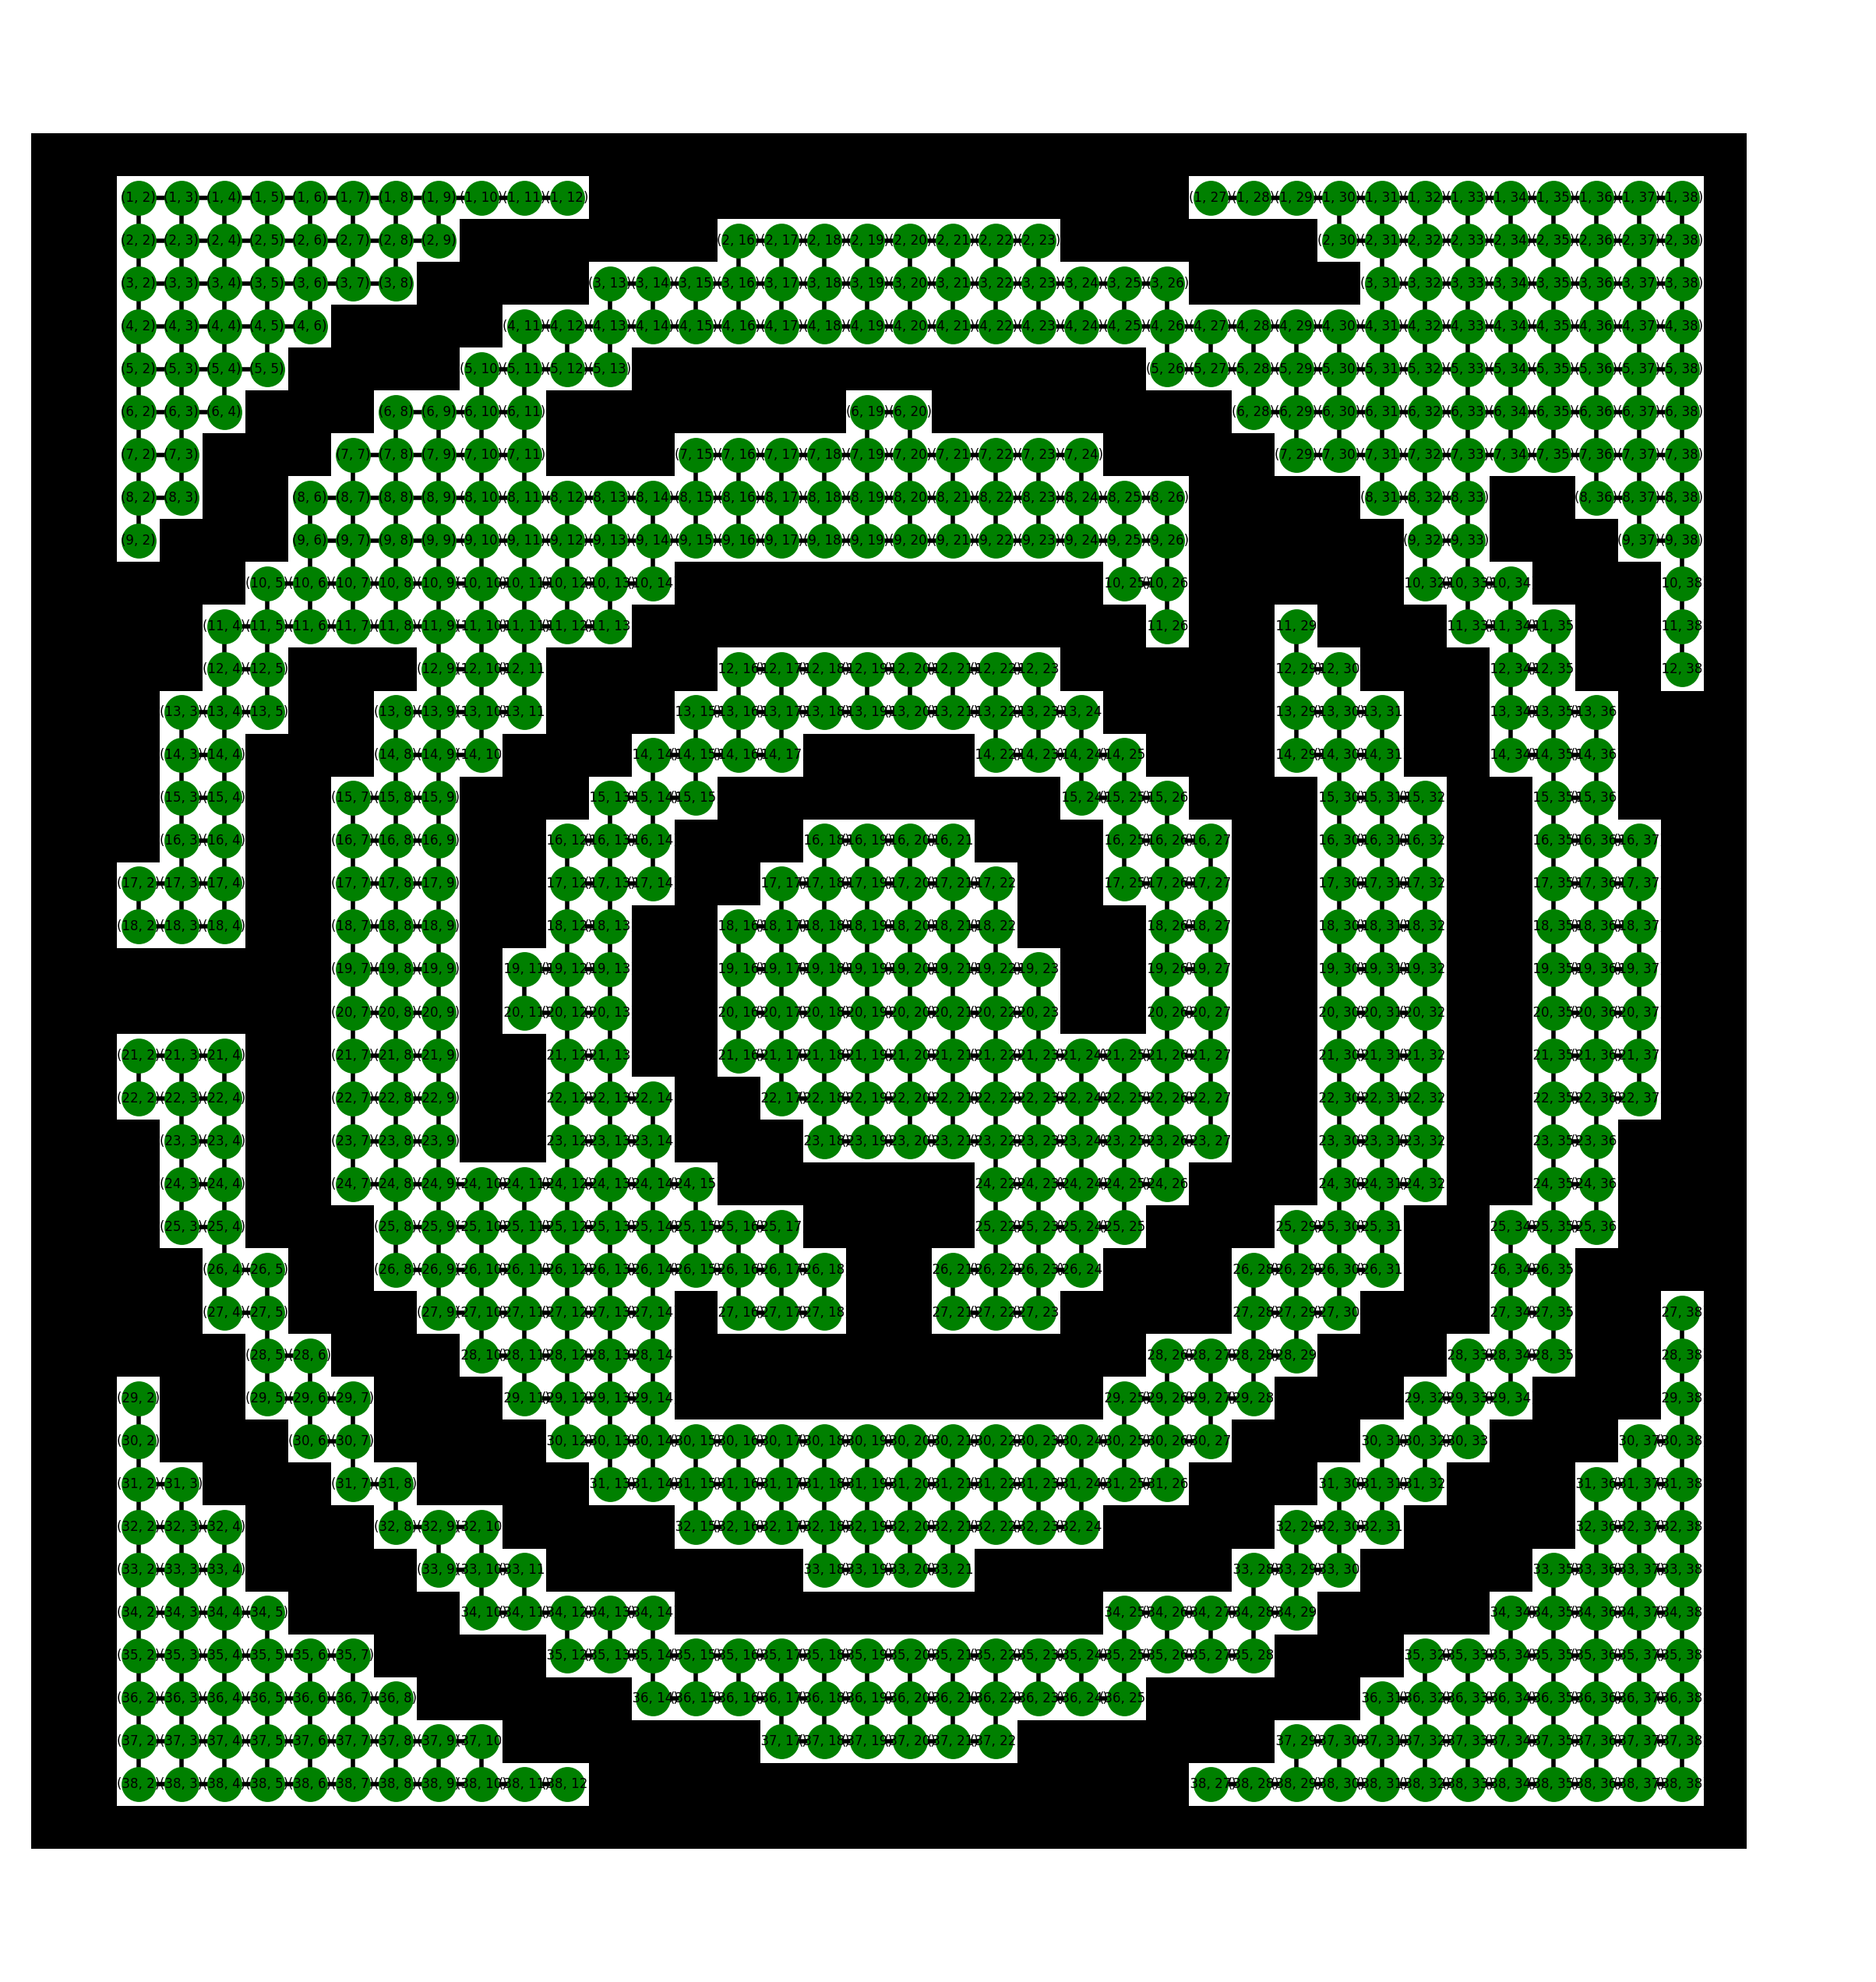

In [211]:

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


if CREATE_PLOTS:
    fig = plt.figure(figsize=(8,8), dpi=400)
    ax = fig.add_subplot(111, aspect='equal')

    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    # Os vértices serão plotados no centro da célula  
    pos = { node: (node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes() }
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

### Determinar menor caminho

Menor caminho identificado


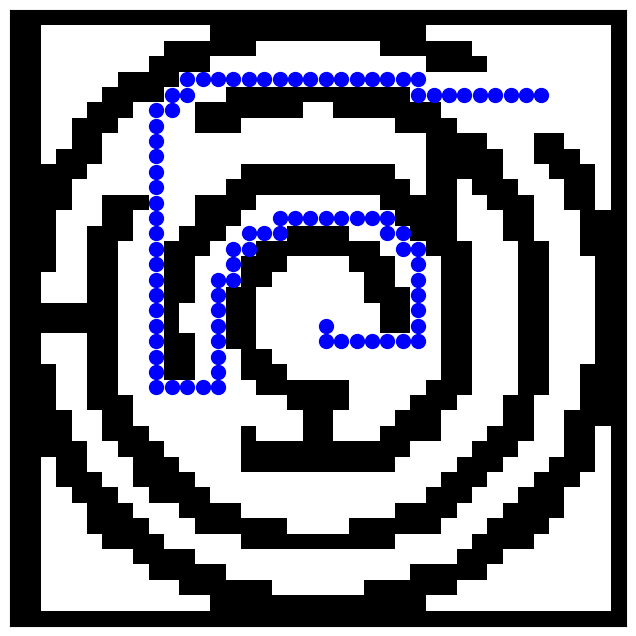

In [212]:
path = nx.shortest_path(G, source=start_node, target=end_node)

if CREATE_PLOTS:
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

print("Menor caminho identificado")

## Movendo o robô

In [213]:
print("TODO")
print("Usando os pontos:")
print(path)
print(f"Mover o robo de {start_node} ate {end_node}")

def Rz(theta):
    return np.array(
        [[ np.cos(theta), -np.sin(theta), 0 ],
         [ np.sin(theta), np.cos(theta) , 0 ],
         [ 0            , 0             , 1 ]])


TODO
Usando os pontos:
[(5, 34), (5, 33), (5, 32), (5, 31), (5, 30), (5, 29), (5, 28), (5, 27), (5, 26), (4, 26), (4, 25), (4, 24), (4, 23), (4, 22), (4, 21), (4, 20), (4, 19), (4, 18), (4, 17), (4, 16), (4, 15), (4, 14), (4, 13), (4, 12), (4, 11), (5, 11), (5, 10), (6, 10), (6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (11, 9), (12, 9), (13, 9), (14, 9), (15, 9), (16, 9), (17, 9), (18, 9), (19, 9), (20, 9), (21, 9), (22, 9), (23, 9), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (23, 13), (22, 13), (21, 13), (20, 13), (19, 13), (18, 13), (17, 13), (17, 14), (16, 14), (15, 14), (15, 15), (14, 15), (14, 16), (14, 17), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23), (13, 24), (14, 24), (14, 25), (15, 25), (15, 26), (16, 26), (17, 26), (18, 26), (19, 26), (20, 26), (21, 26), (21, 25), (21, 24), (21, 23), (21, 22), (21, 21), (21, 20), (20, 20)]
Mover o robo de (5, 34) ate (20, 20)


In [214]:
def convertLinear(s1,s2):
    (low1,up1) = s1
    (low2,up2) = s2
    def fn(x):
        x -= low1
        if low1 > up1: x *= -1
        x /= abs(up1 - low1)
        # Reached 0,1
        x *= abs(up2 - low2)
        if low2 > up2: x *= -1
        x += low2
        return x
    return fn
       
def gridToScene(coords):
    (x,y) = coords
    fx = convertLinear(gridXrange,sceneXrange)
    fy = convertLinear(gridYrange,sceneYrange)
    return (fy(y),fx(x))

def sceneToGrid(coords):
    (x,y) = coords
    fx = convertLinear(sceneXrange,gridXrange)
    fy = convertLinear(sceneYrange,gridYrange)
    return (fy(y),fx(x))


In [215]:
sim.stopSimulation()

# Iniciar o robotino
L = 0.135 # m
r = 0.040 # m
robotino = sim.getObject("/robotino")
start_pos = gridToScene(start_node)
sim.setObjectPosition(robotino,list(map(int,[start_pos[0],start_pos[1],1.99])))

wheels = [0]*3
for i in range(3):
    wheels[i] = sim.getObject(f"/wheel{i}_joint")

    # Parar as rodas inicialmente
    sim.setJointTargetVelocity(wheels[i],0)


In [216]:


# Cinemática Direta
Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
        
# Goal configuration (x, y, theta)    
sim.startSimulation()

for midpoint in path:

    # ? Mudar para cada ponto desejado :)
    curr_goal_pos = gridToScene(midpoint)
    qgoal = np.array([curr_goal_pos[0], curr_goal_pos[1] , 0.05])

    # Frame que representa o Goal
    goalObject = sim.getObject("/Goal")
    sim.setObjectPosition(goalObject,list(map(int,[qgoal[0],qgoal[1],0])))
    sim.setObjectOrientation(goalObject,list(map(int,[0,0,qgoal[2]])))

    gain = [[1.1,0,0],
            [0,1.1,0],
            [0,0,1.1]]

    while True:
        pos = sim.getObjectPosition(robotino)
        ori = sim.getObjectOrientation(robotino)
        q = np.array([pos[0],pos[1],ori[2]])

        error = qgoal - q

        # Margem aceitavel de distancia
        if np.linalg.norm(error[:2]) < 0.3:
            break

        # Controller
        qdot = gain @ error

        # Cinematica Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades
        for i in range(3):
            sim.setJointTargetVelocity(wheels[i], u[i])
    
    print(f"reached {midpoint}")

for i in range(3):
    sim.setJointTargetVelocity(wheels[i], 0)

sim.stopSimulation()


reached (5, 34)
reached (5, 33)
reached (5, 32)
reached (5, 31)
reached (5, 30)
reached (5, 29)
reached (5, 28)
reached (5, 27)
reached (5, 26)
reached (4, 26)
reached (4, 25)
reached (4, 24)
reached (4, 23)
reached (4, 22)
reached (4, 21)
reached (4, 20)
reached (4, 19)
reached (4, 18)
reached (4, 17)
reached (4, 16)
reached (4, 15)
reached (4, 14)
reached (4, 13)
reached (4, 12)
reached (4, 11)
reached (5, 11)
reached (5, 10)
reached (6, 10)
reached (6, 9)
reached (7, 9)
reached (8, 9)
reached (9, 9)
reached (10, 9)
reached (11, 9)
reached (12, 9)
reached (13, 9)
reached (14, 9)
reached (15, 9)
reached (16, 9)
reached (17, 9)
reached (18, 9)
reached (19, 9)
reached (20, 9)
reached (21, 9)
reached (22, 9)
reached (23, 9)
reached (24, 9)
reached (24, 10)
reached (24, 11)
reached (24, 12)
reached (24, 13)
reached (23, 13)
reached (22, 13)
reached (21, 13)
reached (20, 13)
reached (19, 13)
reached (18, 13)
reached (17, 13)
reached (17, 14)
reached (16, 14)
reached (15, 14)
reached (15, 1